### Import Dependencies

In [1]:
import os
import sys

import matplotlib
import pandas as pd
import shap
from scipy import stats
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split

/home/sgunaseelan/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialize Gait Table

In [2]:
def gait_df_init():
       gait_df = pd.read_csv("csv-input/gait-table.csv", index_col=0)
       gait_df.fillna(0)

       gait_feats = [
              "Cadence_L", "Cadence_R", 
              "DblSupport_L", "DblSupport_R", 
              "ElevMidswing_L", "ElevMidswing_R", 
              "CycleDur_L", "CycleDur_R",
              "Speed_L", "Speed_R",
              "Circumdxn_L", "Circumdxn_R",
              "HSAngle_L", "HSAngle_R",
              "TOffAngle_L", "TOffAngle_R",
              "SglSupport_L", "SglSupport_R", 
              "Stance_L", "Stance_R", 
              "StepDur_L", "StepDur_R",
              "StrideLength_L", "StrideLength_R", 
              "Swing_L", "Swing_R",
              "TermDblSupport_L", "TermDblSupport_R", 
              "ToeOutAngle_L", "ToeOutAngle_R", 
              "LumbarCorROM", "LumbarSagROM", "LumbarTransvROM",
              "TrunkCorROM", "TrunkSagROM", "TrunkTransvROM", 
              "ArmSwingVel_L", "ArmSwingVel_R", "ArmROM_L", "ArmROM_R"
       ]

       # Group left and right features
       feat_dict = {}
       updated_gait_feats = []
       for feat in gait_feats:
              if "_" in feat:
                     group, side = feat.split("_")
                     if group not in feat_dict:
                            feat_dict[group] = ["", ""]
                     feat_dict[group][0 if side == "L" else 1] = feat
              else:
                     updated_gait_feats.append(feat)

       # Calculate mean between both left and right for feature, append to gait table
       for group, [left, right] in feat_dict.items():
              gait_df[group] = gait_df[[left, right]].mean(axis=1)

       return gait_df

### Calculate Benefit

In [3]:
def calculate_benefit(gait_df, condition, feature):
    # Condition
    condition_gait_df = gait_df[gait_df["Subject"].str.contains(condition)].reset_index(drop=True)
    # Is .dropna() needed?
    condition_gait_df = condition_gait_df[["Subject", "Cycle_Index", "Condition", feature]].pivot_table(index=["Subject", "Cycle_Index"], columns="Condition", values=feature).dropna().reset_index()

    # Feature
    condition_gait_df = condition_gait_df.rename(columns={"walk": f"Initial_{feature}", "walkAuditory": f"Auditory_{feature}", "walkVisual": f"Visual_{feature}"})

    pvalue_dict = {}
    for subject, subject_df in condition_gait_df.groupby("Subject"):
        _, auditory_pvalue = stats.ttest_ind(subject_df[f"Auditory_{feature}"], subject_df[f"Initial_{feature}"], equal_var=False, alternative="greater")
        _, visual_pvalue = stats.ttest_ind(subject_df[f"Visual_{feature}"], subject_df[f"Initial_{feature}"], equal_var=False, alternative="greater")
        pvalue_dict[subject] = (auditory_pvalue, visual_pvalue)

    condition_benefit_df = pd.DataFrame([(subject, auditory_pvalue, visual_pvalue) for subject, (auditory_pvalue, visual_pvalue) in pvalue_dict.items()], columns=["Subject", "Auditory_pvalue", "Visual_pvalue"])
    condition_benefit_df[f"{feature}_Auditory_Benefit"] = (condition_benefit_df["Auditory_pvalue"] < 0.05).astype(int)
    condition_benefit_df[f"{feature}_Visual_Benefit"] = (condition_benefit_df["Visual_pvalue"] < 0.05).astype(int)

    # OR auditory and visual benefit
    condition_benefit_df[f"{feature}_Benefit"] = condition_benefit_df[f"{feature}_Auditory_Benefit"] | condition_benefit_df[f"{feature}_Visual_Benefit"]

    return condition_benefit_df


def create_benefit_df(gait_df):
    # Stride length
    stride_benefit_df = calculate_benefit(gait_df, "PD", "StrideLength")
    # Speed
    speed_benefit_df = calculate_benefit(gait_df, "PD", "Speed")

    return stride_benefit_df, speed_benefit_df

### Prepare Gait Table

In [4]:
# Prepare gait table
def prepare_gait_df(gait_df, pd_stride_benefit_df, condition, feature, cue="", OR=False):
    pd_gait_df = gait_df[gait_df["Subject"].str.contains(condition)].reset_index(drop=True)
    pd_gait_df = pd_gait_df.groupby(["Subject", "age", "group", "UPDRS III TOTAL:"])[[feature]].mean().reset_index()
    pd_gait_df = pd_gait_df.rename(columns={feature: f"Initial_{feature}_Avg"})
    pd_gait_df = pd_gait_df.loc[~(pd_gait_df["Subject"] == "sub-PD33")].reset_index(drop=True)  # Exclude sub-PD33, no walk run

    pd_log_reg_df = pd_stride_benefit_df.join(pd_gait_df[["age", "group", "UPDRS III TOTAL:", f"Initial_{feature}_Avg"]])
    if OR:
        pd_log_reg_df = pd_log_reg_df[["Subject", "age", "group", "UPDRS III TOTAL:", f"Initial_{feature}_Avg", f"{feature}_Benefit"]]
    else:
        pd_log_reg_df = pd_log_reg_df[["Subject", "age", "group", "UPDRS III TOTAL:", f"Initial_{feature}_Avg", f"{feature}_{cue}_Benefit"]]
    
    return pd_log_reg_df

### SHAP

- Use SHAP to explain logistic regression model

In [5]:
def SHAP(X, log_reg):
    def log_reg_log_odds(x):
        p = log_reg.predict_log_proba(x)
        return p[:, 1] - p[:, 0]

    # Compute the SHAP values for the linear model
    background_adult = shap.maskers.Independent(X, max_samples=100)
    explainer_log_odds = shap.Explainer(log_reg_log_odds, background_adult)
    shap_values_adult_log_odds = explainer_log_odds(X)

    # Use a beeswarm plot to summarize the entire distribution of SHAP values for each feature
    shap.plots.beeswarm(shap_values_adult_log_odds)

### Logistic Regression

In [6]:
def prep_log_reg_xy(pd_log_reg_df, feature, cue="", OR=False):
    if OR:
        X = pd_log_reg_df.drop(columns=["Subject", f"{feature}_Benefit"])
        y = pd_log_reg_df[f"{feature}_Benefit"]
    else:
        X = pd_log_reg_df.drop(columns=["Subject", f"{feature}_{cue}_Benefit"])
        y = pd_log_reg_df[f"{feature}_{cue}_Benefit"]
    
    X = pd.get_dummies(X, columns=["group"], drop_first=True)
    X["group_nofog"] = X["group_nofog"].astype(int)

    return X, y

def train_log_reg(X, y):
    # Train logistic regression model (60% data for training, 40% data for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
    log_reg = linear_model.LogisticRegression()
    log_reg.fit(X_train, y_train)
    SHAP(X, log_reg)
    y_pred = log_reg.predict(X_test)
    print(metrics.accuracy_score(y_test, y_pred))

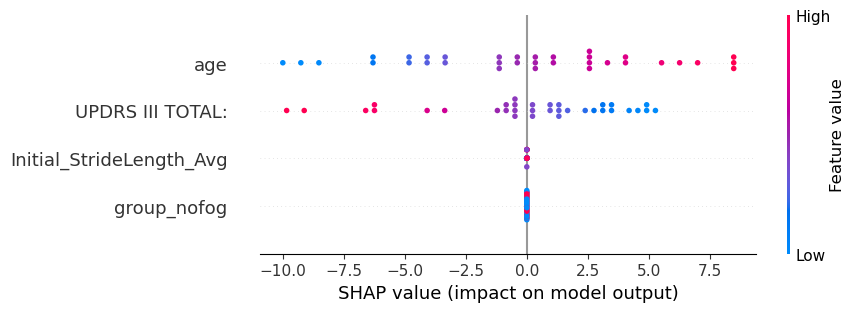

0.8235294117647058


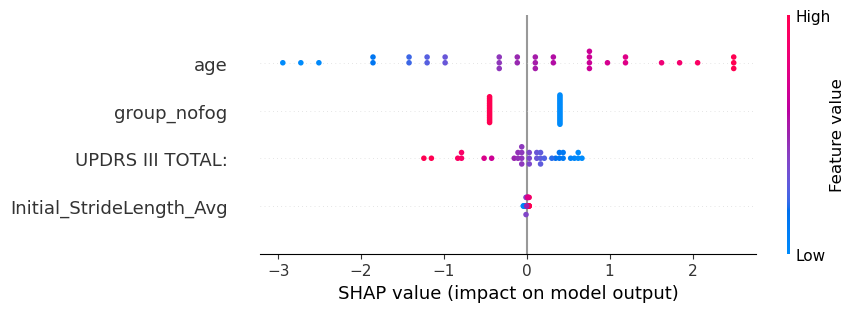

0.47058823529411764


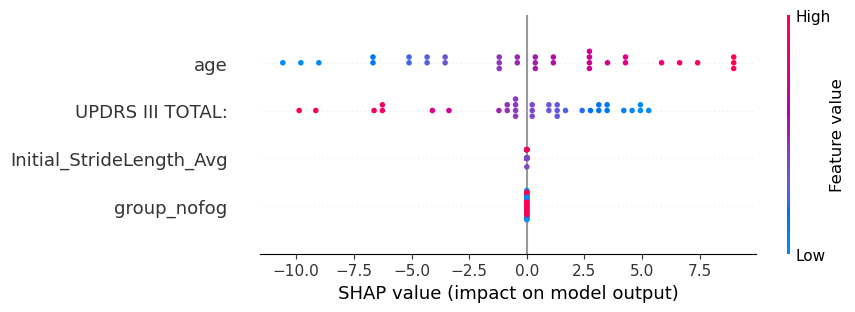

0.8235294117647058


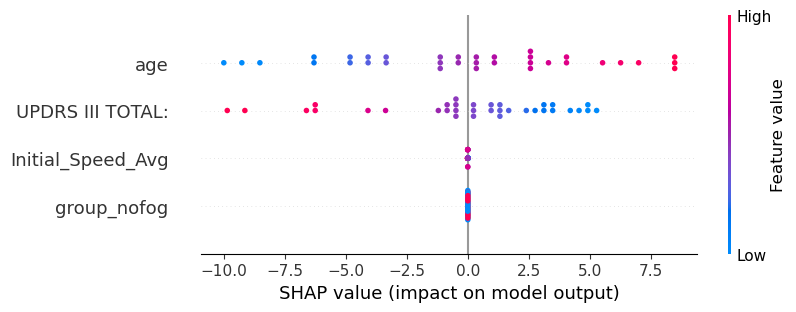

0.8235294117647058


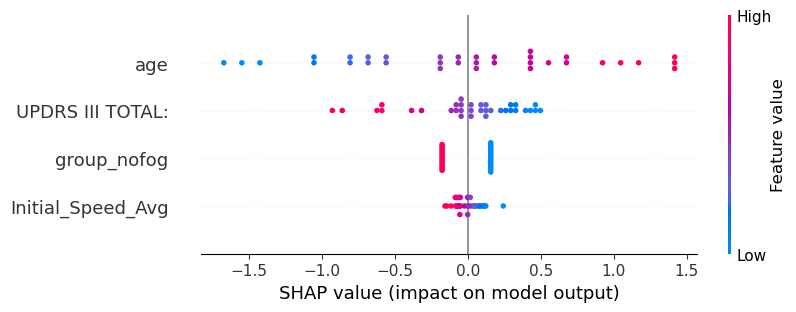

0.35294117647058826


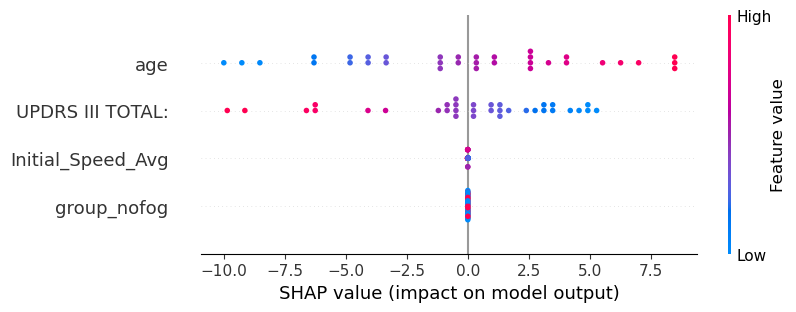

0.8823529411764706


In [7]:
def main():
    # Initialize gait table
    gait_df = gait_df_init()

    # Calculate benefit
    pd_stride_benefit_df, pd_speed_benefit_df = create_benefit_df(gait_df)
    # Output (for debugging purposes)
    pd_stride_benefit_df.to_csv("csv-output/stride_benefit_table.csv")
    pd_speed_benefit_df.to_csv("csv-output/speed_benefit_table.csv")    
    
    # Apply logistic regression model

    # Stride length
    pd_log_reg_df = prepare_gait_df(gait_df, pd_stride_benefit_df, "PD", "StrideLength", "Auditory")
    X, y = prep_log_reg_xy(pd_log_reg_df,"StrideLength", "Auditory")  # Auditory
    train_log_reg(X, y)
    pd_log_reg_df = prepare_gait_df(gait_df, pd_stride_benefit_df, "PD", "StrideLength", "Visual")
    X, y = prep_log_reg_xy(pd_log_reg_df,"StrideLength", "Visual")  # Visual
    train_log_reg(X, y)
    # Combined (auditory OR visual)
    pd_log_reg_df = prepare_gait_df(gait_df, pd_stride_benefit_df, "PD", "StrideLength", OR=True)
    X, y = prep_log_reg_xy(pd_log_reg_df, "StrideLength", OR=True)
    train_log_reg(X, y)

    # Speed
    pd_log_reg_df = prepare_gait_df(gait_df, pd_speed_benefit_df, "PD", "Speed", "Auditory")
    X, y = prep_log_reg_xy(pd_log_reg_df, "Speed", "Auditory")  # Auditory
    train_log_reg(X, y)
    pd_log_reg_df = prepare_gait_df(gait_df, pd_speed_benefit_df, "PD", "Speed", "Visual")
    X, y = prep_log_reg_xy(pd_log_reg_df, "Speed", "Visual")  # Visual
    train_log_reg(X, y)
    # Combined (auditory OR visual)
    pd_log_reg_df = prepare_gait_df(gait_df, pd_speed_benefit_df, "PD", "Speed", OR=True)
    X, y = prep_log_reg_xy(pd_log_reg_df, "Speed", OR=True)
    train_log_reg(X, y)

    # Output
    pd_log_reg_df.to_csv("csv-output/pd_log_reg.csv")

    
if __name__ == "__main__":
    main()